### Read the dataset in from Kaggle

In [ ]:
import json

! pip install kaggle
! mkdir /root/.kaggle/

token = {"username": "stensalumets", "key": "87f48d7a114c6e2d96984b04f6eaa078"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

! chmod 600 /root/.kaggle/kaggle.json

! kaggle competitions download -c nlp-getting-started


  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 32.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.6MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 38.5MB/s]


In [ ]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Preprocessing

Concatenate the two datasets two preprocess them equally.

In [ ]:
df1 = train.copy() 
df1['source'] = 'train'

df2 = test.copy() 
df2['source'] = 'test'

# TODO
data = pd.concat([df1, df2], sort=False)
data

,id,keyword,location,text,target,source
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,train
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,train
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,train
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,train
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,train
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,test
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,test
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,test
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,test


Remove stopwords and lematize (puts words to their root form)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def remove_stop_words(sentence):
  sentence_minus_sw = []
  stop_words = stopwords.words('english')
  sentence = sentence.split()
  sentence = [sentence_minus_sw.append(word) for word in sentence if word not in stop_words]
  review = ' '.join(sentence_minus_sw)
  return review

def lematize(sentence):
    lemmatizer = WordNetLemmatizer()
    sentence = sentence.split()
    sentence = [lemmatizer.lemmatize(word) for word in sentence]
    sentence = ' '.join(sentence)
    return sentence

data['text'] = [ lematize(remove_stop_words(x)) for x in data['text'] ]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Encode the text to numbers. The smaller the number, the more popular the word.

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

#top_words=20000
t = Tokenizer() #num_words= top_words could be added

list_of_text = [text_to_word_sequence(text) for text in list(data['text'])]

t.fit_on_texts(list_of_text)
data['text_processed'] = t.texts_to_sequences(list_of_text)

print("Vocabulary consists of", len(t.word_counts), "words.")
top_words = len(t.word_counts) + 1

Vocabulary consists of 28848 words.


In [ ]:
print(data['text'].iloc[0])
print(data['text_processed'].iloc[0])

Our Deeds Reason #earthquake May ALLAH Forgive u
[697, 5738, 590, 216, 108, 1760, 3716, 20]


Split back into train and test

In [ ]:
train = data[(data["source"] == "train")].drop(columns="source")
test = data[(data["source"] == "test")].drop(columns=["source", "target"])

See how balanced our dataset is (Not used)

In [ ]:
train_positive = len(train[(train['target']) == 1])
train_negative = len(train[(train['target']) == 0])

print(train_positive)
print(train_negative)

3271
4342


Balance the dataset (Not used)

In [ ]:
positive_cases = train[train['target'] == 1]
negative_sample = train[train['target'] == 0].sample(n=train_positive, random_state=11)
train_balanced = pd.concat([positive_cases, negative_sample])
train_balanced.sort_index(inplace=True)

train_positive = len(train_balanced[(train_balanced['target']) == 1])
train_negative = len(train_balanced[(train_balanced['target']) == 0])

print(train_positive)
print(train_negative)

3271
3271


Split train into train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

print(len(train), "\n")
x_train, x_val, y_train, y_val = train_test_split(train['text_processed'], train['target'], test_size=round(len(train)*0.3), random_state=11)

print("Shape of train set:")
print(x_train.shape)
print(y_train.shape)


x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=round(len(x_val)/3), random_state=11)

print("Shape of validation set:")
print(x_val.shape)
print(y_val.shape)
print("Shape of test set:")
print(x_test.shape)
print(y_test.shape)


7613 

Shape of train set:
(5329,)
(5329,)
Shape of validation set:
(1523,)
(1523,)
Shape of test set:
(761,)
(761,)


Padding the data samples to a maximum review length in words. Optimal padding to be determined later.


In [ ]:
from keras.preprocessing import sequence

max_words = 30
x = sequence.pad_sequences(train['text_processed'], maxlen=max_words, padding='post')
y = train['target']

x_train = sequence.pad_sequences(x_train, maxlen=max_words, padding='post') #maxlen=max_words, could be added. Currently pads according to the longest line
x_val = sequence.pad_sequences(x_val, maxlen=max_words, padding='post')
x_test = sequence.pad_sequences(x_test, maxlen=max_words, padding='post')
test = sequence.pad_sequences(test['text_processed'], maxlen=max_words, padding='post')

### Try to do some CNN

https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9

In [ ]:
from keras.models import Sequential

from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras import regularizers

def getModel():
  model = Sequential()
  embedding_dim = 32

  # Adding the embedding layer which will take words as input and provide a 200 dimensional output of those words which belong in the top_words dictionary
  model.add(Embedding(top_words, embedding_dim, input_length=max_words))

  #Then, we add the convolutional layer and max-pooling layer.
  model.add(Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(MaxPooling1D())

  #Finally, we flatten those matrices into vectors and add dense layers(basically scale,rotating and transform the vector by multiplying Matrix and vector).
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
  #model.add(Dropout(0.5))

  #The last Dense layer is having one as parameter because we are doing a binary classification and so we need only one output node in our vector.
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            923168    
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 100)               44900     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

https://www.kaggle.com/franklemuchahary/basic-cnn-keras-with-cross-validation

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_accuracy', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('best_cnn.h5', verbose=1, save_best_only=True, monitor="val_accuracy")

#define a function to fit the model
def fit_and_evaluate(train_x, val_x, train_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = getModel()
    results = model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
import numpy as np

#Now, we will fit our training data and define the the epochs(number of passes through dataset) 
#and batch size(nunmber of samples processed before updating the model) for our learning model.

#Batch size is kept greater than or equal to 1 and less than the number of samples in training data.

#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128, verbose=2)

n_folds=10
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x, y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 1.7514 - accuracy: 0.5736
Epoch 00001: val_accuracy improved from -inf to 0.61079, saving model to best_cnn.h5
49/49 [==============================] - 14s 32ms/step - loss: 1.7514 - accuracy: 0.5736 - val_loss: 1.1217 - val_accuracy: 0.6108
Epoch 2/20
47/49 [===========================>..] - ETA: 0s - loss: 0.8395 - accuracy: 0.7522
Epoch 00002: val_accuracy improved from 0.61079 to 0.73324, saving model to best_cnn.h5
49/49 [==============================] - 1s 19ms/step - loss: 0.8339 - accuracy: 0.7544 - val_loss: 0.6939 - val_accuracy: 0.7332
Epoch 3/20
49/49 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8793
Epoch 00003: val_accuracy improved from 0.73324 to 0.76968, saving model to best_cnn.h5
49/49 [==============================] - 1s 16ms/step - loss: 0.4668 - accuracy: 0.8793 - val_loss: 0.6454 - val_accuracy: 0.7697
Epoch 4/20
49/49 [===========================

In [ ]:
from keras.models import load_model


model = load_model('best_cnn.h5')

scores = model.evaluate(x_test, y_test)

print("Accuracy: %.2f%%" % (scores[1]*100))

#dropout 0.8 = 78.2
#dropout 0.1 = 77.32
#dropout 0.95 = 76.36
#dropout 0.5 = 77.76
#ilma dropoutita 78.11

from sklearn.metrics import f1_score
print("F1 score: ", f1_score(y_test, [0 if x < 0.5 else 1 for x in model.predict(x_test)]))


24/24 [==============================] - 0s 5ms/step - loss: 0.3770 - accuracy: 0.9054
Accuracy: 90.54%
F1 score:  0.8803986710963454


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


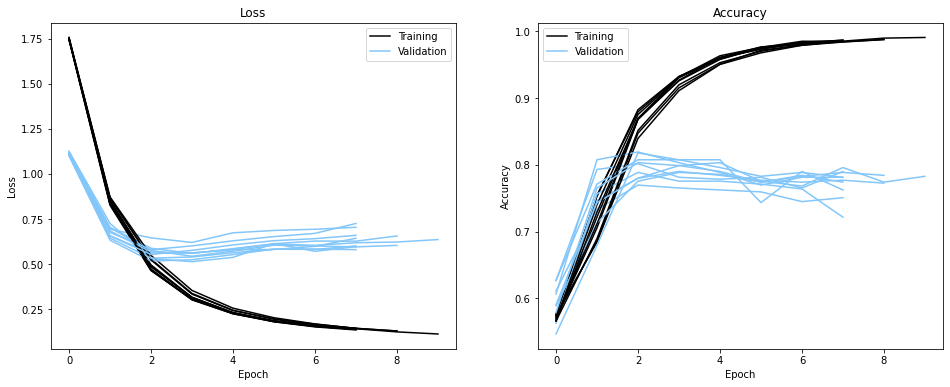

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

def plot_curves(history, color, color2):

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], color=color)
  plt.plot(history.history['val_loss'], color=color2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], color=color)
  plt.plot(history.history['val_accuracy'], color=color2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy')

plot_curves(model_history[0], 'black', '#83c6fa')
plot_curves(model_history[1], 'black', '#83c6fa')
plot_curves(model_history[2], 'black', '#83c6fa')
plot_curves(model_history[3], 'black', '#83c6fa')
plot_curves(model_history[4], 'black', '#83c6fa')
plot_curves(model_history[5], 'black', '#83c6fa')
plot_curves(model_history[6], 'black', '#83c6fa')
plot_curves(model_history[7], 'black', '#83c6fa')
plot_curves(model_history[8], 'black', '#83c6fa')
plot_curves(model_history[9], 'black', '#83c6fa')

In [ ]:
import numpy as np

proba_predict = pd.DataFrame({'id':pd.read_csv("test.csv")['id']})
proba_predict['target'] = [0 if x < 0.5 else 1 for x in model.predict(test)]

proba_predict
proba_predict.to_csv('CNN_NLP.csv', index=False)

! kaggle competitions submit -c nlp-getting-started -f CNN_NLP.csv -m "CNN NLP submission 3 with CV, low embedding"


100% 22.2k/22.2k [00:01<00:00, 11.8kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets